# Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, precision_recall_fscore_support, accuracy_score, classification_report, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [2]:
# Załadowanie danych
train_df = pd.read_csv('train_df.csv', index_col=0)
test_df = pd.read_csv('test_df.csv', index_col=0)

# Oznaczenie zbioru treningowego i testowego
train_df['__is_train'] = 1
test_df['__is_train'] = 0

# Połączenie zbiorów
combined = pd.concat([train_df, test_df], axis=0)

# Kodowanie One-Hot Encoding
combined = pd.get_dummies(combined, drop_first=True)
train_df = combined[combined['__is_train'] == 1].drop(columns='__is_train')
test_df = combined[combined['__is_train'] == 0].drop(columns='__is_train')

# Podział na cechy i etykiety
X_train = train_df.drop('stroke', axis=1)
y_train = train_df['stroke']
X_test = test_df.drop('stroke', axis=1)
y_test = test_df['stroke']

In [3]:
# Indeksy cech kategorycznych po One-Hot Encoding
index_of_categorical_features = [1, 2, 5, 6, 7, 8, 9, 10, 11]

# Zastosowanie SMOTENC
sm = SMOTENC(categorical_features=index_of_categorical_features, random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

## Grid Search – dobór optymalnych hiperparametrów

In [36]:
# Parametry do Grid Search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=0
)

print("Rozpoczynam Grid Search dla Drzewa Decyzyjnego...")
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik AUC: {grid_search.best_score_}")

Rozpoczynam Grid Search dla Drzewa Decyzyjnego...
Najlepsze parametry: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Najlepszy wynik AUC: 0.8156093745053972


In [37]:
# Inicjalizacja modelu z najlepszymi parametrami
best_dt_model = DecisionTreeClassifier(
    random_state=42,
    **grid_search.best_params_
)

# Trenowanie modelu
print("Trenowanie Drzewa Decyzyjnego...")
best_dt_model.fit(X_train_resampled, y_train_resampled)

Trenowanie Drzewa Decyzyjnego...


DecisionTreeClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                       random_state=42)

## Ocena modelu

In [39]:
# Przewidywanie prawdopodobieństw
y_proba = best_dt_model.predict_proba(X_test)[:, 1]

# Zastosowanie progu 0.5 do generowania prognoz binarnych
y_pred = (y_proba >= 0.5).astype(int)

# Obliczanie metryk
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Wyświetlenie wyników
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")

Confusion Matrix:
[[586 382]
 [  3  51]]
Accuracy: 0.6233
AUC: 0.8320
TPR (Recall): 0.9444
Macro avg Precision: 0.5563
Macro avg Recall: 0.7749
Macro avg F1-score: 0.4811


In [40]:
# Przewidywanie prawdopodobieństw
y_proba = best_dt_model.predict_proba(X_test)[:, 1]

# Zmniejszenie do 0.3
y_pred = (y_proba >= 0.3).astype(int)

# Obliczanie metryk
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Wyświetlenie wyników
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")

Confusion Matrix:
[[586 382]
 [  3  51]]
Accuracy: 0.6233
AUC: 0.8320
TPR (Recall): 0.9444
Macro avg Precision: 0.5563
Macro avg Recall: 0.7749
Macro avg F1-score: 0.4811


## Wizualizacja drzewa

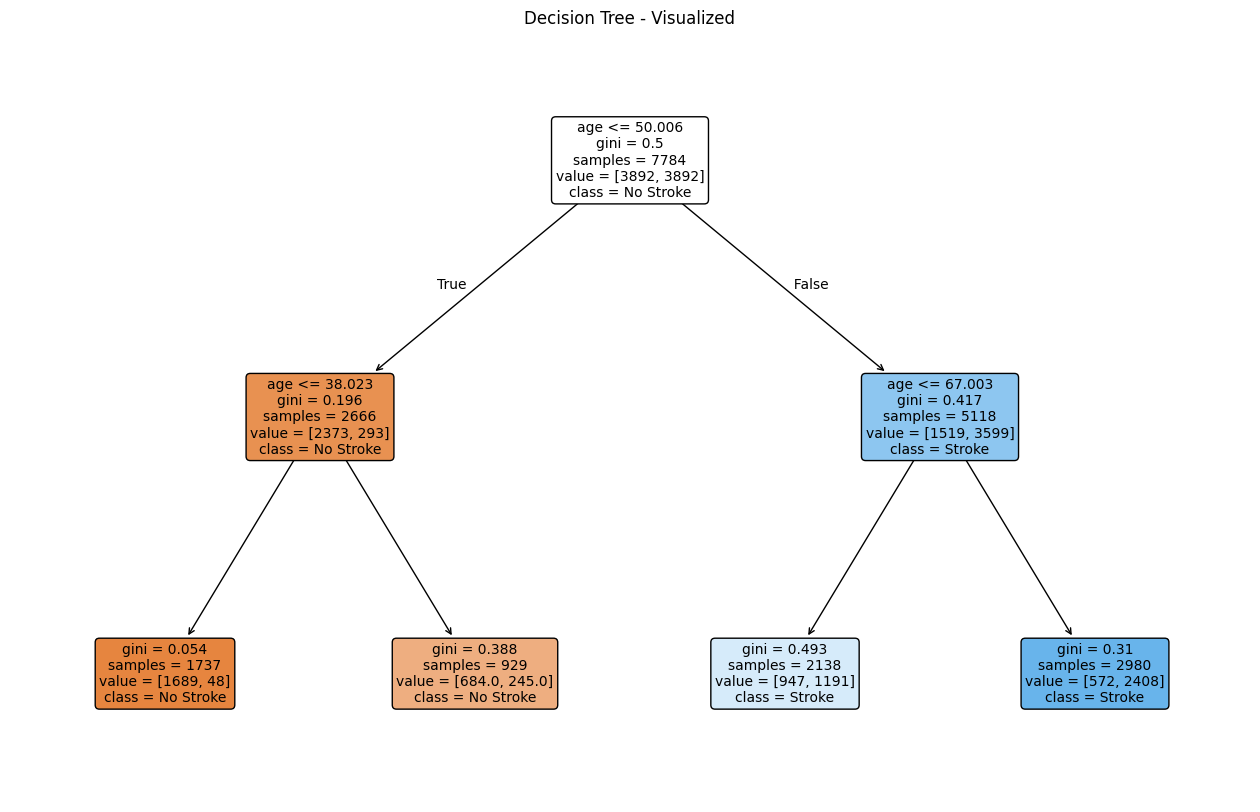

In [41]:
plt.figure(figsize=(16, 10))
plot_tree(best_dt_model, 
          feature_names=X_train.columns, 
          class_names=['No Stroke', 'Stroke'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree - Visualized")
plt.show()

## Wizualizacja metryk

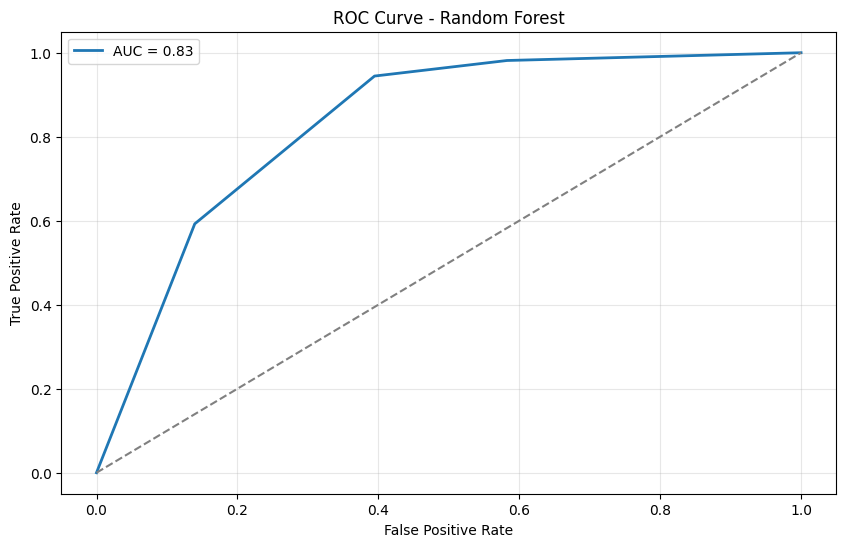

In [42]:
# Wizualizacja krzywej ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc), linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

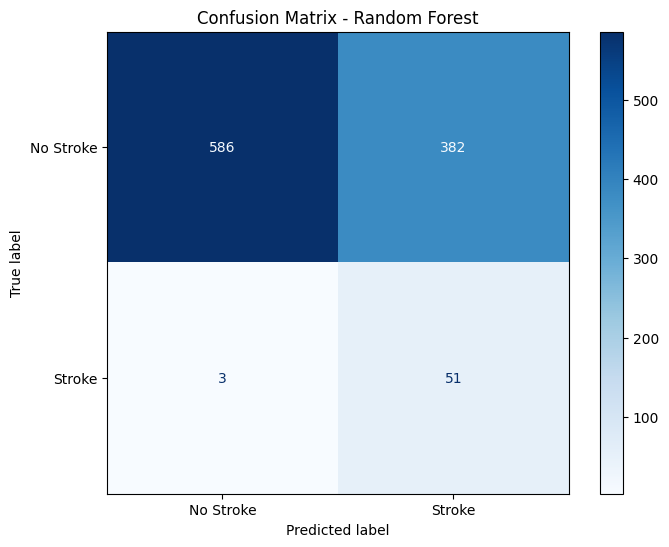

In [43]:
# Generowanie confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

# Wykres confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

## Podsumowanie metryk

1. AUC: 0.8320
2. TPR (Recall): 0.9444
3. Macro avg Precision: 0.5563
4. Macro avg Recall: 0.7749
5. Macro avg F1-score: 0.4811